## Preparation

### Import nessasary libraries

In [10]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data

from torchvision import models
from torchvision import transforms
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

cudnn.benchmark = True
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

### Define or import functions

In [11]:
from torchcam.methods import SmoothGradCAMpp

from algorithms import tensor_imshow, get_class_name, RISE

# Set the size of the input image.
input_size = (224, 224)

# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

# Read the input image as a tensor.
input_tensor = read_tensor('examples/antelope.jpg')

### Load black-box model

In [12]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

c:\Users\jerry2137\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\jerry2137\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\jerry2137/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s] 


### Create the explainer instance

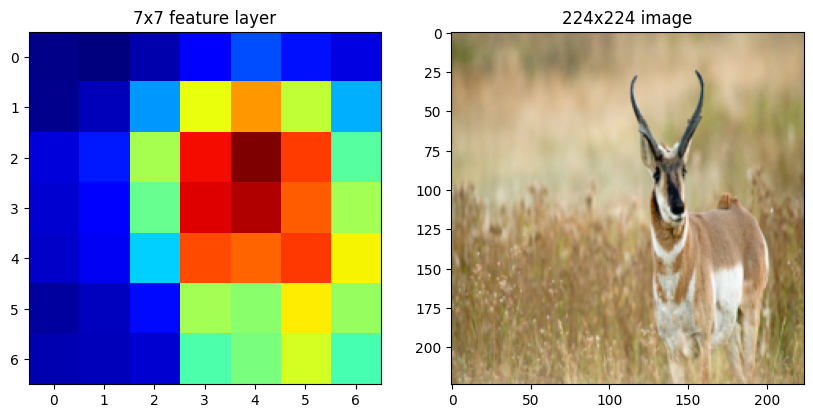

In [13]:
input_tensor.requires_grad = True

# Save the saliency maps.
gradcam_sals_top = []

# Hook the model with a Grad-CAM extractor and designated a layer (or it will select the feature layer automatically).
with SmoothGradCAMpp(model) as cam_extractor:

    # Feed the image into the model and get the output predicted classes.
    out = model(input_tensor.cuda())
    probabilities, classes = torch.topk(out, k=1)
    classes = classes[0]

    # Feed output and a desired class into the Grad-CAM extractor to generate a feature saliency map with the size of the feature layer.
    gradcam_sal = cam_extractor(classes[0].item(), out)[0]
    gradcam_sal_flatten = gradcam_sal.flatten()

    layer_name = cam_extractor.target_names[0]

input_tensor.requires_grad = False

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('7x7 feature layer')
plt.imshow(np.asarray(gradcam_sal[0].cpu()), cmap='jet')

plt.subplot(1, 2, 2)
plt.title('224x224 image')
tensor_imshow(input_tensor[0])

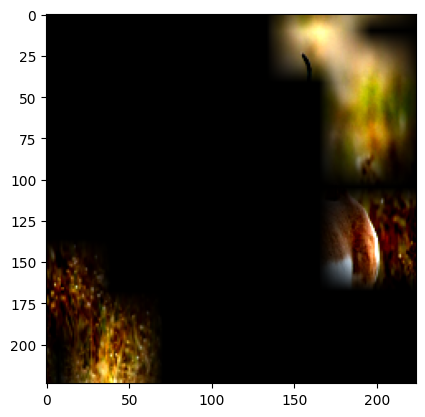

In [14]:
# Generate and save (or load) masks for a presice explanation.
N = 5000

rise_explainer = RISE(model, input_size)
rise_explainer.generate_masks(N=N, s=8, p1=0.1, savepath=mask_path)
masks = rise_explainer.masks


masked_imgs = torch.mul(masks, input_tensor.cuda())

In [15]:
def generate_rectangular_masks(mask_number, mask_size, img_size):
    masks = torch.ones(mask_number, 1, img_size[0], img_size[1])
    mask_half_height, mask_half_width = mask_size[0]//2, mask_size[1]//2
    mask_center_x = torch.randint(0-mask_half_height, img_size[0]+mask_half_height, (mask_number,))
    mask_center_y = torch.randint(0-mask_half_width, img_size[1]+mask_half_width, (mask_number,))
    top = torch.max(torch.full_like(mask_center_x, 0), mask_center_x-mask_half_height)
    buttom = torch.min(torch.full_like(mask_center_x, img_size[0]), mask_center_x+mask_half_height)
    left = torch.max(torch.full_like(mask_center_y, 0), mask_center_y-mask_half_width)
    right = torch.min(torch.full_like(mask_center_y, img_size[1]), mask_center_y+mask_half_width)
    for i in range(mask_number):
        masks[i, :, top[i]:buttom[i], left[i]:right[i]] = 0

    return masks

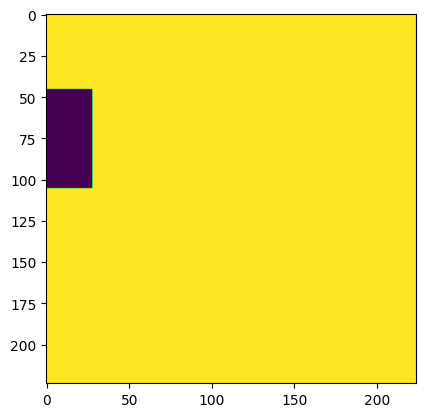

In [16]:
masks = generate_rectangular_masks(N, (60, 60), input_size)
masked_img_np = np.asarray(masks[0].squeeze().cpu())
plt.imshow(masked_img_np)

In [17]:
masks.shape

torch.Size([15000, 1, 224, 224])

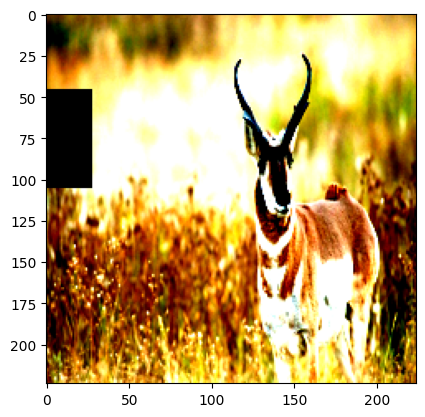

In [18]:
masks = masks.cuda()
masked_imgs = torch.mul(masks, input_tensor.cuda())

masked_img_np = np.asarray(masked_imgs[0].cpu().squeeze().permute(1,2,0))
plt.imshow(masked_img_np, cmap='jet')

In [19]:
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(m, i, o):
            activation[name] = o.detach()

        return hook

    model.get_submodule(layer).register_forward_hook(get_activation(layer))
    _ = model(x)
    return activation[layer]

In [20]:
# Get the feature maps of the original image.
feature = get_hidden_features(input_tensor.cuda(), layer_name)
feature.shape

torch.Size([1, 2048, 7, 7])

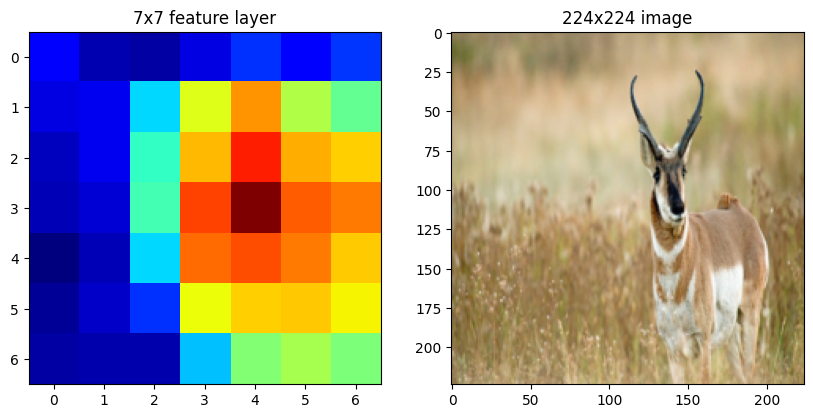

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('7x7 feature layer')
feature_image = torch.sum(feature, dim=1).cpu()
plt.imshow(np.asarray(feature_image[0]), cmap='jet')

plt.subplot(1, 2, 2)
plt.title('224x224 image')
tensor_imshow(input_tensor[0])

In [22]:
masked_feature_list = []
for masked_img in tqdm.tqdm(masked_imgs):
    masked_feature_list.append(get_hidden_features(masked_img[None, :, :, :], layer_name))

100%|██████████| 15000/15000 [06:58<00:00, 35.84it/s]


In [23]:
masked_features = torch.cat(masked_feature_list)
masked_features.shape

torch.Size([15000, 2048, 7, 7])

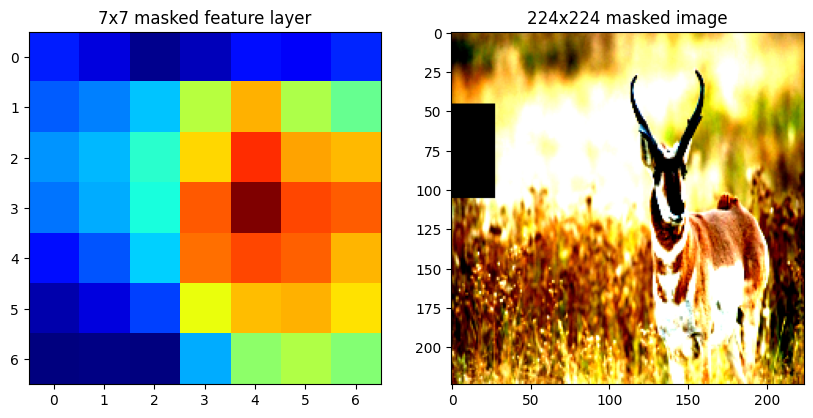

In [24]:
nth_mask = 0

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('7x7 masked feature layer')
masked_features_sum = torch.sum(masked_features, dim=1).cpu()
plt.imshow(np.asarray(masked_features_sum[nth_mask]), cmap='jet')

plt.subplot(1, 2, 2)
plt.title('224x224 masked image')
masked_img_np = np.asarray(masked_imgs[nth_mask].cpu().squeeze().permute(1,2,0))
plt.imshow(masked_img_np, cmap='jet')

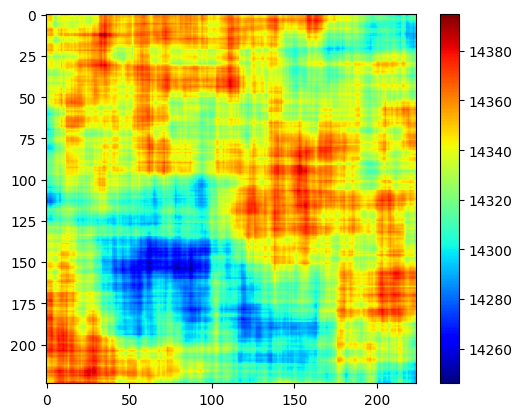

In [25]:
masked_sum = torch.sum(masks, dim=0).cpu()
plt.imshow(np.asarray(masked_sum[0]), cmap='jet')
plt.colorbar()

In [26]:
a_points = torch.Tensor([[4,3], [1,1]])
b_points = torch.Tensor([[0,0], [4,5]])

torch.sqrt(torch.sum(torch.pow(torch.subtract(a_points, b_points), 2), dim=1))

tensor([5., 5.])

In [27]:
# Distance between the masked features and the original features.
weights = torch.sqrt(torch.sum(torch.pow(torch.subtract(masked_features, feature), 2), dim=1))
weights.shape

torch.Size([15000, 7, 7])

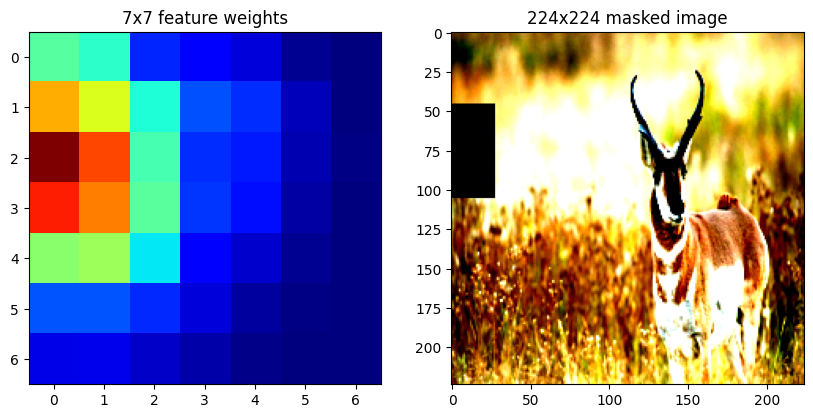

In [28]:
nth_mask = 0

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('7x7 feature weights')
plt.imshow(np.asarray(weights[nth_mask].cpu()), cmap='jet')

plt.subplot(1, 2, 2)
plt.title('224x224 masked image')
masked_img_np = np.asarray(masked_imgs[nth_mask].cpu().squeeze().permute(1,2,0))
plt.imshow(masked_img_np, cmap='jet')

In [29]:
weights_reshaped = torch.flatten(weights, start_dim=1, end_dim=2).T
masks_reshaped = 1 - torch.flatten(masks, start_dim=1, end_dim=3)
weights_reshaped.shape, masks_reshaped.shape

(torch.Size([49, 15000]), torch.Size([15000, 50176]))

In [30]:
feature_saliency_maps_flatten = torch.matmul(weights_reshaped, masks_reshaped)
feature_saliency_maps_flatten.shape

torch.Size([49, 50176])

In [31]:
feature_saliency_maps = torch.unflatten(feature_saliency_maps_flatten, 1, (224, 224))
feature_saliency_maps.shape

torch.Size([49, 224, 224])

In [32]:
torch.sort(gradcam_sal_flatten, descending=True).indices[0]

tensor(18, device='cuda:0')

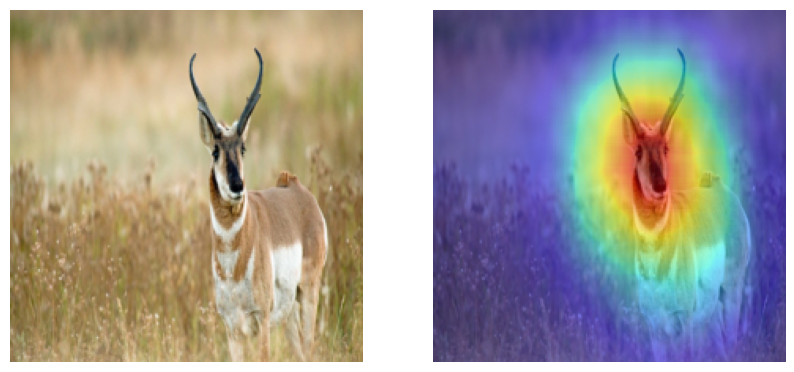

In [33]:
nth_feature = 25

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.axis('off')
tensor_imshow(input_tensor[0])

plt.subplot(122)
plt.axis('off')
tensor_imshow(input_tensor[0])

# index = torch.sort(gradcam_sal_flatten, descending=True).indices[nth_feature]
# saliency_map_n = weighted_masks[index]
saliency_map_n = feature_saliency_maps[nth_feature]
plt.imshow(saliency_map_n.cpu(), cmap='jet', alpha=0.5)

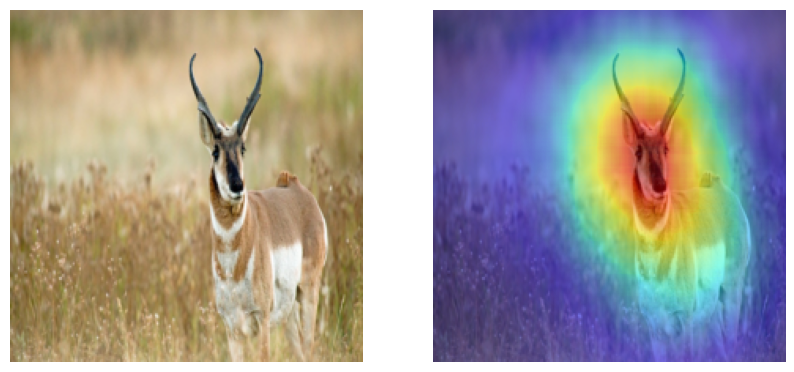

In [34]:
nth_feature = 5

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.axis('off')
tensor_imshow(input_tensor[0])

plt.subplot(122)
plt.axis('off')
tensor_imshow(input_tensor[0])

indices = torch.topk(gradcam_sal_flatten, nth_feature)[1]
saliency_map_n = torch.sum(feature_saliency_maps[indices], dim=0)
plt.imshow(saliency_map_n.cpu(), cmap='jet', alpha=0.5)

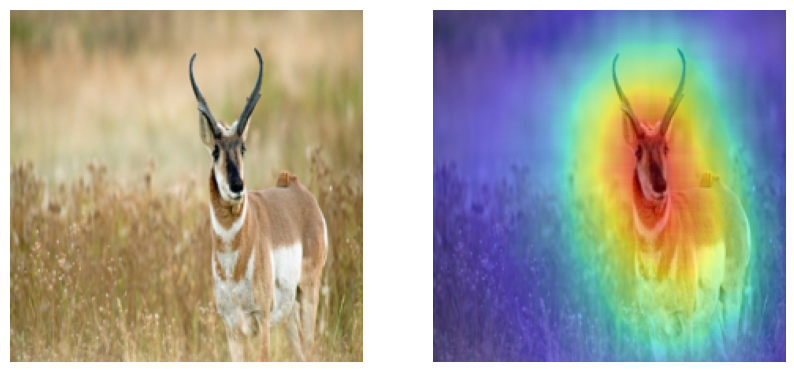

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.axis('off')
tensor_imshow(input_tensor[0])

plt.subplot(122)
plt.axis('off')
tensor_imshow(input_tensor[0])
saliency_map_weighted = torch.sum(torch.mul(feature_saliency_maps, gradcam_sal_flatten[:, None, None]), dim=0)
plt.imshow(saliency_map_weighted.cpu(), cmap='jet', alpha=0.5)

In [36]:
def generate_rectangular_masks_weighted(mask_number, mask_size, img_size, distribution):
    masks = torch.ones(mask_number, 1, img_size[0], img_size[1])
    mask_half_height, mask_half_width = mask_size[0]//2, mask_size[1]//2

    distribution = np.pad(distribution, [[mask_half_height]*2,[mask_half_width]*2], constant_values=distribution.min())
    distribution_flatten = distribution.flatten()
    distribution_normalized = distribution_flatten / distribution_flatten.sum()

    points_number = np.random.choice(
        a=np.arange(0, (img_size[0]+mask_size[0])*(img_size[1]+mask_size[1])),
        size=mask_number,
        p=distribution_normalized,
    )
    masks_center_x = points_number // (img_size[0]+mask_size[0]) - mask_half_height
    masks_center_y = points_number % (img_size[1]+mask_size[1]) - mask_half_width
    top = np.maximum(np.full_like(masks_center_x, 0), masks_center_x-mask_half_height)
    buttom = np.minimum(np.full_like(masks_center_x, img_size[0]), masks_center_x+mask_half_height)
    left = np.maximum(np.full_like(masks_center_y, 0), masks_center_y-mask_half_width)
    right = np.minimum(np.full_like(masks_center_y, img_size[1]), masks_center_y+mask_half_width)
    for i in range(mask_number):
        masks[i, :, top[i]:buttom[i], left[i]:right[i]] = 0

    return masks

In [37]:
saliency_map_weighted_np = saliency_map_weighted.detach().cpu().numpy()
X_min = saliency_map_weighted_np.min()
X_max = saliency_map_weighted_np.max()
saliency_map_normalized_np = saliency_map_weighted_np / saliency_map_weighted_np.sum()

masks = generate_rectangular_masks_weighted(10000, (30, 30), input_size, saliency_map_normalized_np)

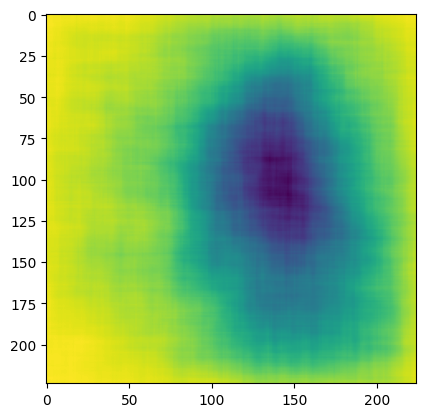

In [38]:
plt.imshow(masks.sum(dim=0)[0])

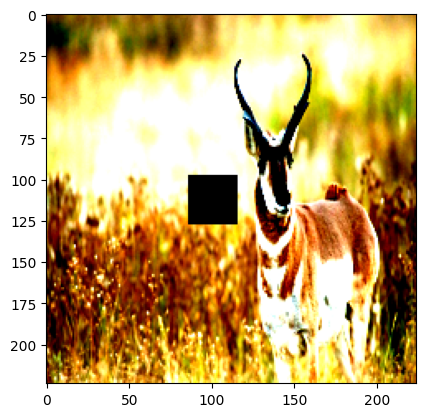

In [39]:
masks = masks.cuda()
masked_imgs = torch.mul(masks, input_tensor.cuda())

masked_img_np = np.asarray(masked_imgs[0].cpu().squeeze().permute(1,2,0))
plt.imshow(masked_img_np, cmap='jet')